# boundary_conditions

> Create slip-wall boundary conditions, create initial conditions for "primitive streak" (disk), and "germ band" (rectangle), and run simulations with patterned feedback parameter


In [ ]:
#| default_exp boundary_jax

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize
from scipy import linalg

from tqdm.notebook import tqdm

from copy import deepcopy

from collections import Counter, defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial
from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
#config.update("jax_debug_nans", True)  # useful for debugging, but makes code slower!

## creating initial conditions

In [ ]:
#| export

def get_triangular_lattice(nx, ny):
    """get triangular lattice with nx, ny points. Return a mask which delinates bdry vertices""" 

    y = np.arange(0, ny)*sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2; Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    is_bdry = np.zeros_like(X)
    is_bdry[:1] = is_bdry[-1:] = 1
    is_bdry[:,:1] = is_bdry[:,-1:] = 1
    is_bdry = is_bdry.reshape(nx*ny)
    
    return pts, is_bdry

def create_rect_mesh(nx, ny, noise=0, defects=(0,0), straight_bdry=False):
    pts, is_bdry = get_triangular_lattice(nx, ny)
    pts[:,~is_bdry.astype(bool)] += np.random.normal(scale=noise, size=(2, (~is_bdry.astype(bool)).sum()))
    if defects[0] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[0], replace=False)
        pts = np.delete(pts, ix, axis=1)
    if defects[1] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[1], replace=False)
        split = np.random.choice((0,1), len(ix))
        additional_pts =  pts[:, ix] + .3*np.stack([1-split, split]) 
        pts[:, ix] -= .3*np.stack([1-split, split]) 
        pts = np.hstack([pts, additional_pts])
    
    tri = spatial.Delaunay(pts.T)
    # remove the left, right edge
    if straight_bdry:
        simplices = tri.simplices
    else:
        max_x, min_x = (pts[0].max(), pts[0].min())
        simplices = np.stack([x for x in tri.simplices
                          if (np.isclose(pts[0,x], min_x).sum()<2) and (np.isclose(pts[0,x], max_x).sum()<2)])
    pre_mesh = ListOfVerticesAndFaces(tri.points, simplices)
    mesh = HalfEdgeMesh(pre_mesh)
    
    return mesh

# might want to add the corner pts.

## Making a colored cell plot

Moved code to 00 notebook

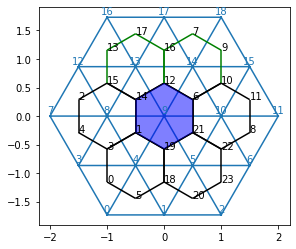

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_voronoi()
mesh.set_rest_lengths()

passive_ids = [13, 17, 16, 7, 9]
passive_edges = flatten([[he._heid for he in mesh.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "g" for key in passive_edges}

cell_colors = {9: (0,0,1,.5)}

mesh.cellplot(edge_colors=edge_colors, cell_colors=cell_colors, )
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

## Convenience methods for vertices

In [ ]:
#| export

@patch
def is_bdry(self: Vertex):
    """False if the vertex is on the boundar"""
    return None in self.get_face_neighbors()

@patch
def get_centroid(self: Vertex):
    """Get centroid of dual cell"""
    return np.mean([x.dual_coords for x in self.get_face_neighbors() if x is not None], axis=0)

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=13) # (7,7)
mesh.set_voronoi()

mesh.vertices[20].get_centroid(), mesh.vertices[20].is_bdry(), mesh.vertices[1].is_bdry()

(array([ 1.        , -3.46410162]), False, True)

## Experimentation with jax

In [ ]:
#| export

@patch
def get_primal_energy_fct_jax(self: HalfEdgeMesh, bdry_list=None):
    """Get arrays necessary to compute primal energy from primal vertices. Cell based shape tensor.
    bdry_list: [(penalty function, vertex ids),]
    """

    # book-keeping
    face_keys = sorted(self.faces.keys())
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    n_faces = len(self.faces)
    
    # stuff for boundary energy
    bdry_list = [] if bdry_list is None else bdry_list
    bdry_list = [bdry + [[]] for bdry in bdry_list] #  3rd entry is for the cell ids 
    
    # stuff for the shape tensor energy
    cell_list = []
    rest_shapes = []
    # for future "convenience" also return a vector of _vids corresponding to the cell list
    cell_list_vids = []
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            cell = jnp.array([face_key_dict[fc._fid] for fc in neighbors])
            cell_list.append(cell)
            cell_list_vids.append(v._vid)
            # check if the cell is in any bdry:
            for bdry in bdry_list:
                if v._vid in bdry[1]:
                    bdry[2].append(len(cell_list)-1)
            
            rest_shapes.append(v.rest_shape)
    valences = [len(cell) for cell in cell_list]
    max_valence = max(valences)
    valence_mask = jnp.array([x*[1,]+(max_valence-x)*[0,] for x in valences])
    # valence mask = (n_cells, max_valence). entry for each cell indicates whether a vertex is a duplicate
    cell_list = jnp.array([jnp.pad(cell, (0, max_valence-len(cell)), mode="edge") for cell in cell_list])
    rest_shapes = jnp.stack(rest_shapes)
    bdry_list = [[bdry[0], jnp.array(bdry[2])] for bdry in bdry_list]

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            # rotate by 90 degrees
            dual_edge = jnp.array([dual_edge[1], -dual_edge[0]])
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]] # 0= he, 1= twin
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = jnp.array(e_dual)
    e_lst_primal = jnp.array(e_lst_primal)        
    
    return (e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask), np.array(cell_list_vids)

In [ ]:
#| export

@jit
def get_E(x0, e_lst_primal, e_dual, cell_list, rest_shapes, bdry_list, valence_mask,
          mod_bulk=1, mod_shear=.1, angle_penalty=100, bdry_penalty=10, epsilon_l=1e-3):
    n_faces = int(x0.shape[0]/2)
    x, y = (x0[:n_faces], x0[n_faces:])
    pts = jnp.stack([x, y], axis=-1)
#   print('pts', pts.shape)
    # face-based shape energy
    cells = jnp.stack([pts[i] for i in cell_list.T], axis=0)
    # axis order migt be important here for performance!
#   print('cell list', cell_list.shape)h
#   print('cells', cells.shape)
    edges = cells - jnp.roll(cells, 1, axis=0)
#    print('edges', edges.shape)
    lengths = jnp.sqrt(jnp.sum(edges**2, axis=-1)+epsilon_l**2)
    # + epsilon**2 to avoid non-differentiable sqrt at 0-length edges (occur due to padding)
    units = (edges.T/lengths.T).T
    tensors = jnp.einsum('efi,efj->fij', edges, units)
    delta = tensors - rest_shapes
#   print('tensors', delta.shape)
    E_shape = jnp.mean(mod_shear*jnp.sum(delta**2, axis=(1,2)) + 
                       mod_bulk*(delta[:,0,0]+delta[:,1,1])**2)

    # angle penalty
    e_primal = pts[e_lst_primal[:,1],:] - pts[e_lst_primal[:,0],:] # he.twin.face-he.face
    lengths = jnp.sqrt(jnp.sum(e_primal**2, axis=-1)+epsilon_l**2)
    # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
    E_angle = angle_penalty*jnp.mean(1-jnp.einsum('ei,ei->e', e_primal, e_dual)/lengths)
    
    # boundary conditions
    E_bdry = 0
    for bdry in bdry_list:
#       print("cells, bdry[1], valence_mask", cells.shape, bdry[1].shape, valence_mask.shape)
        centroids = (jnp.sum(cells[:,bdry[1]].T*valence_mask[bdry[1]], axis=-1)
                     /jnp.sum(valence_mask[bdry[1]],axis=-1))
#       print("centroids", centroids.shape)
        E_bdry = E_bdry + bdry_penalty*jnp.sum(bdry[0](centroids)) # shape (2, n_cells_in_bdry)
    return E_shape + E_angle + E_bdry

get_E_jac = jit(jgrad(get_E))
#get_E_jac = jgrad(get_E)

## Example of cell shape optimization with JAX

In [ ]:
# format: penalty function, ids of cells. Need to wrap penalty function in jax.tree_util.Partial.
y_max = 4.3

def up_penalty(x):
    return (x[1]-y_max)**2
def down_penalty(x):
    return (x[1]+y_max)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

# trigger compile
_ = up_penalty(np.array([1,1])), down_penalty(np.array([1,1]))

# need to define this once and reuse since it is jitted

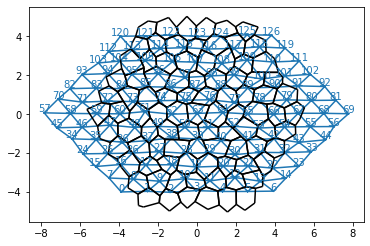

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=13, nx=13) # (7,7)

mesh.set_voronoi()
mesh.set_rest_lengths()

for v in mesh.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=0.1))
mesh.transform_vertices(lambda x: shear_mat(1.3)@x+np.random.normal(size=2, scale=0.05)) #0.075

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");

bdry_up = [up_penalty, [113, 114, 115, 116, ]] # 117, 118 
bdry_down = [down_penalty, [8, 9, 10, 11, ]] # 1, -y_max 12, 13
bdry_list = (bdry_up, bdry_down)

In [ ]:
mod_bulk = 1
mod_shear = .5
angle_penalty = 500
bdry_penalty = 50

epsilon_l = 1e-3

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh.get_primal_energy_fct_jax(bdry_list)

# create a vector of bulk moduli for active and passive cells

passive_ids = bdry_up[1]+bdry_down[1] # for example

act_pass_mask = np.vectorize(lambda x: 1-.9*(x in passive_ids))(cell_list_vids)
mod_bulk_vec = mod_bulk*act_pass_mask
mod_shear_vec = act_pass_mask*mod_shear

cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l)

In [ ]:
_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))

get_E(x0, *(get_E_arrays+cell_shape_args))

DeviceArray(25.94904264, dtype=float64)

In [ ]:
%timeit get_E(x0, *(get_E_arrays+cell_shape_args))
%timeit get_E_jac(x0, *(get_E_arrays+cell_shape_args))

# worse now?? why, used to be 25 & 44 mu. Not due to the new length function. Not due to bdry. Not due to angle
# must be due to new shape of operations in shape

22.6 µs ± 815 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
43.8 µs ± 404 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-4, options={"maxiter": 1000})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

# takes: 580ms with BFGS, 30 ms with CG. Hessian-based methods are not really better


# New values for get_E_arrays trigger this

Maximum number of iterations has been exceeded. n_eval:  1537 1537
0.08626078993979969 300.8208325031597
CPU times: user 285 ms, sys: 0 ns, total: 285 ms
Wall time: 285 ms


In [ ]:
mesh_new = deepcopy(mesh)

new_coord_dict = mesh_new.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh_new.faces.items():
    val.dual_coords = new_coord_dict[key]

In [ ]:
(np.mean([val for val in mesh_new.get_angle_deviation().values()]),
 np.mean([val for val in mesh.get_angle_deviation().values()]))

(0.0020557077597875666, 0.2519372089775207)

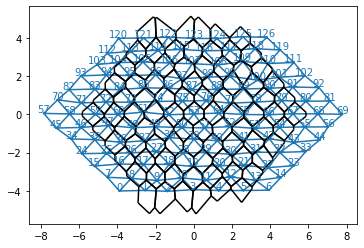

In [ ]:
mesh_new.cellplot()
mesh_new.triplot()
mesh_new.labelplot(face_labels=False)

plt.gca().set_aspect("equal", adjustable="box");


## JAX speedup


#### Pre jax rewrite (13x13 mesh):
`get_E`: 321 micro s
`jac`: 2.57 ms
`optimize.minimize` with `BFGS`: 1.25 s
`optimize.minimize` with `CG`: 2.5 s


#### Post jax rewrite, using jit:

`get_E`: 13 micro s
`jac`: 30 micro s
`optimize.minimize` with `BFGS`: 560 ms, 
`optimize.minimize` with `CG`: 110 ms, 


Problem: massive speedup in energy function and gradient evaluation not translated into optimizer performance. The reason being that the optimizer only spends ca 1/3 of its time doing function/jacobian evaluations!

With the now much lower cost, using a routine which makes more function calls can be faster. In particular CG. Which is now much faster. This the yields an overall speedup of 10x.


Can sometimes terminate with precision loss error. But only at large noise I think? Desired error not necessarily achieved due to precision loss.

## Rescale set of points to match another!

Allowed: rotation, translation, scaling. Fix scaling by taking area

In [ ]:
#| export

@patch
def get_bdry(self: HalfEdgeMesh):
    """get boundary hes. Works if boundary is simply connected. Could be modified for general case"""
    bdry = []
    start = next(he for he in self.hes.values() if he.face is None)
    he = start
    returned = False
    while not returned:
        bdry.append(he)
        he = he.nxt
        returned = (he==start)
    return bdry

def get_conformal_transform(mesh1, mesh2):
    """Get rotation+scaling+translation to match mesh2's triangulation to mesh1. Preserves overall area"""
    bdry1 = np.stack([he.vertices[0].coords for he in mesh1.get_bdry()])
    bdry2 = np.stack([he.vertices[0].coords for he in mesh2.get_bdry()])
    rescale = np.sqrt(polygon_area(bdry1)/polygon_area(bdry2))

    pts1 = np.stack([v.coords for v in mesh1.vertices.values()])
    pts2 = np.stack([v.coords for v in mesh2.vertices.values()])
    mean1, mean2 = (pts1.mean(axis=0), pts2.mean(axis=0))

    rotation = linalg.orthogonal_procrustes(rescale*(pts2-mean2), pts1-mean1)[0]

    return lambda x: rotation.T@(rescale*(x-mean2))+mean1


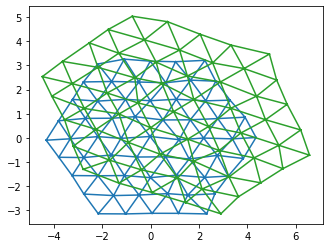

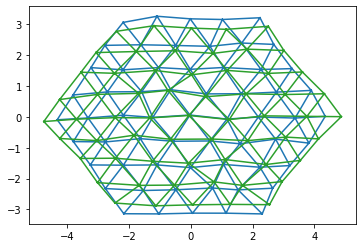

In [ ]:
mesh1 = get_tri_hemesh(noise=0, ny=9, nx=9) # (7,7)
mesh1.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=0.05)) #0.075
mesh2 = deepcopy(mesh1)
mesh2.transform_vertices(lambda x: 1.2*rot_mat(.3)@shear_mat(1.1)@x+np.random.normal(loc=1, size=2, scale=0.05))

mesh1.triplot()
mesh2.triplot()
plt.gca().set_aspect("equal", adjustable="box");
plt.show()

mesh2.transform_vertices(get_conformal_transform(mesh1, mesh2))

mesh1.triplot()
mesh2.triplot()
plt.gca().set_aspect("equal", adjustable="box");
plt.show()

In [ ]:
[polygon_area(np.stack([he.vertices[0].coords for he in x.get_bdry()])) for x in [mesh1, mesh2]]

[41.240888087391156, 41.24088808739114]

## Timestepping wrappers

Needed to re-write them

To - do: In a refactoring step, put the boundary energy back into notebook 3. Probably want to do everything with JAX from now, need to do rewrite.

Else, try a germ band with only half a lateral side

In [ ]:
#| export
@patch
def euler_step(self: HalfEdgeMesh, dt=.005, rhs=excitable_dt_post, params=None,
               rhs_rest_shape=None):
    """RHS: callable Ts, Tps -> dTs_dt, dTps_dt. Params can either be a dict of keyword args
    to the RHS function, or a callable faceid -> keyword dict.
    rhs_rest_shape: v -> d_rest_shape_dt, for rest shape dynamics (e.g. viscous relaxation)
    """
    rhs_rest_shape = (lambda v: 0) if rhs_rest_shape is None else rhs_rest_shape
    for fc in self.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        if isinstance(params, dict):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params)
        elif callable(params):
            dT_dt, dTp_dt = rhs(Ts, Tps, **params(fc._fid))
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    for v in self.vertices.values():
        v.rest_shape += dt*rhs_rest_shape(v)


In [ ]:
#| export
@patch
def flatten_triangulation(self: HalfEdgeMesh, tol=1e-3, verbose=True, reg_A=0, A0=sqrt(3)/4):
    """Flatten triangulation"""
    get_E, grd = self.get_energy_fct(reg_A=0, A0=A0)
    x0 = self.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=tol)
    if sol["status"] !=0 and verbose:
        print("Triangulation optimization failed")
        print(sol["message"])
    new_coord_dict = self.initial_cond_to_vertices(sol["x"])
    for key, val in self.vertices.items():
        val.coords = new_coord_dict[key]
    self.set_rest_lengths()


In [ ]:
#is the reset rest lengths step now working??

In [ ]:
#| export
@patch
def optimize_cell_shape(self: HalfEdgeMesh, bdry_list=None,
                        energy_args=None, cell_id_to_modulus=None,
                        tol=1e-3, maxiter=500, verbose=True):
    """Primal optimization. cell_id_to_modulus: function from _vid to relative elastic modulus"""
    x0 = mesh.dual_vertices_to_initial_cond()
    get_E_arrays, cell_list_vids = mesh.get_primal_energy_fct_jax(bdry_list)

    if energy_args is None:
        energy_args = {"mod_bulk": 1, "mod_shear": .2,"angle_penalty": 1000, "bdry_penalty": 100,
                       "epsilon_l": 1e-4}
    if cell_id_to_modulus is not None:
        mod_bulk = energy_args["mod_bulk"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
        mod_shear = energy_args["mod_shear"]*np.vectorize(cell_id_to_modulus)(cell_list_vids)
    else:
        mod_bulk, mod_shear = (energy_args["mod_bulk"], energy_args["mod_shear"])
    
    cell_shape_args = (mod_bulk, mod_shear, energy_args["angle_penalty"], energy_args["bdry_penalty"],
                       energy_args["epsilon_l"])
    
    sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                             method="CG", tol=tol, options={"maxiter": maxiter})
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.initial_cond_to_dual_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]

In [ ]:
#| export

def excitable_dt_act_pass(Ts, Tps, k=1, m=2, k3=.2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation. Variant: completely deactivate feedback for m=1.
    k3 is a cutoff in the excitable tension dynamics, for numerical stability at the mesh edges.
    """
    dT_dt = (m-1)*((Ts-Tps)**m - k3*(Ts-Tps)**3 - k*Tps)
    # use relative tension
    #T_mean = Ts.mean()
    #dT_dt = T_mean *((m-1)*(((Ts-Tps)/T_mean)**m - k3*((Ts-Tps)/T_mean)**3 - k*Tps/T_mean ) )
    
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= np.linalg.norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)    
    return dT_dt, dTp_dt

In [ ]:
.1/0.01, 1e1

(10.0, 10.0)

[<matplotlib.lines.Line2D>]

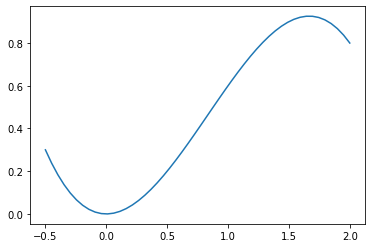

In [ ]:
T = np.linspace(-.5, 2)

plt.plot(T, T**2-.4*T**3)

### Notes
1. no boundary condition -> CE flow as expected. however, the type of boundary (not a clean cut) in create_rect_mesh can lead to problems. so use trimesh for a sec
2. now try patterned feedback. also looks reasonable. now try plotting the shape energies. done
3. now add boundary condition. also works. energy increases!

## Simulation with boundary conditions and passive & active cells

For starters, simply divide the cells into active $m=4$ and passive, $m=1$. Would be better to make this more gradual ofc.  Energy based bdry condition method appears much more reasonable

#### Updates to the elastic energy:

- Do not relax the trace of the rest shape. This way, preserve area
- Need to grade the elastic moduli. Because of bdry conditions, total shape strain + total voronoi strain = 0. Naturally, the shape strain will distribute evenly throughout the tissue and the intercalating cells get stretched so that there is no net extension. Need to localize the shape strain also!


### Problem solved: nan in jacobian

Occurred in cells with 5 edges, where due to padding there is an edge with length 0. This makes the gradient of the square root in the euclidean norm singular. Solution: add $\epsilon$ _before_ taking square root.

### Problem solved: Invalid meshes

After flip. In the while where I re-sort the half edges belonging to a face by traverse.
This might appear if there is a triangle with only two edges, i.e. the topology broke!

Upon investigation of the last valid time point and the flipped edges, I created a configuration in which flips are topologically impossible, and then the flip algorithm exhibits undefined behavior.

Configuration example: triangle where all vertices meet at a 4th vertex inside the triangle. The interior edges cannot be flipped.

This appears to happen at a triangle whose area is vanishing. This might be fixed by adding an area elasticity term to the triangle flattening construction. Also need to detect such topologies in flip algorithm and abort.

In real space, this corresponds to a triangular cell which would lose one of its sides during the T1. Detect by checking the valence (# incoming edges) of both vertices of the half-edge to be flipped. If any is =3, abort.

### Problem solved: triangulation edges collapsing


Creating a `norm` function for color map normalizaton overwrote the `np.linalg.norm` function used in the Euler step, which I had foolishly imported as `norm`. ALWAYS IMPORT WITH PROPER NAMESPACES!!!

## To Do

Wrap the code to create a mesh, and set passive regions, as function!

Rename the`mesh.transform_dual_vertices` method - confusing as it refers to primal vertices

Type of initial condition has the tendency to lead to cable formation!

In [ ]:
## create mesh

np.random.seed(0)
mesh_initial = create_rect_mesh(12, 9, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False

mesh_initial.transform_vertices(rot_mat(pi/2))
center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_centroid()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))  #1
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []
bdry_up_ids = []
bdry_down_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 2
for fc in mesh_initial.faces.values():
    #if fc.is_bdr():  # make a passive edge - let's see if that is necessary
    #    passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

""" 
w_bdry = .5 #.2

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)
"""

w_bdry = .5 #.2

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if ((max_y_cells-.2) > v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (-(max_y_cells-.2)< v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)


In [ ]:
print(max_y_cells)

5.117813939239685


In [ ]:
## create the penalty functions

bdry_y = 4.9

def up_penalty(x):
    return (x[1]-bdry_y)**2
def down_penalty(x):
    return (x[1]+bdry_y)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

bdry_list = ([up_penalty, bdry_up_ids], [down_penalty, bdry_down_ids])

In [ ]:
#| notest
%matplotlib inline

In [ ]:
initial_y_dict = {key: round(round(2*(val.get_centroid()[1]-.2), ndigits=0)/2, ndigits=1)+.25
                  for key, val in mesh_initial.vertices.items()
                  if (not key in passive_cells) and (not val.is_bdry())}

# round to nearest .5
print(set(sorted(list(initial_y_dict.values()))))

vmin, vmax = (-2.75, 2.75)
color_norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.ScalarMappable(norm=color_norm, cmap=mpl.cm.viridis)

alpha = .5
cell_colors = {key: np.array(cmap.to_rgba(val))*np.array([1,1,1,alpha])
               for key, val in initial_y_dict.items()}

{-0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, -2.25, -1.25, -2.75, -1.75}


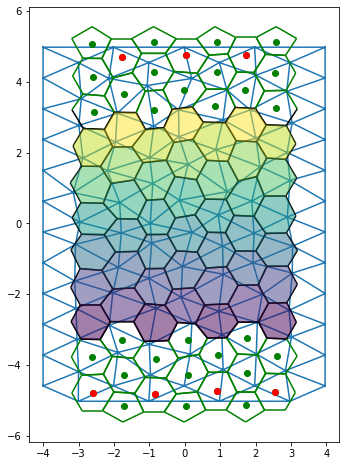

In [ ]:
## plot

passive_edges = flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "g" for key in passive_edges}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
mesh_initial.triplot()

#mesh_initial.labelplot()

for key in passive_cells: # double check passive cells are correctly identified
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="g")

for key in bdry_up_ids+bdry_down_ids:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="r")

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
## set simulation parameters

# function for active and passive
k = 2
k3 = .4 # .25 regularization term
 
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": k, "m": 1}
    return {"k": k, "m": 2, "k3": k3}

params_no_pattern = {"k": k, "m": 2, "k3": k3}

k_rest = .1 # 2
def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    if v._vid in passive_cells:
        delta = v.rest_shape-v.get_shape_tensor()
        return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    else:
        return 0

dt = .01
n_steps = 150
forbid_reflip = 40

minimal_l = .075 # .075
tol, maxiter = (1e-4, 20000) # .5*1e-4, 

mod_bulk = 1
mod_shear = 0.5 # .1
angle_penalty = 1000
bdry_penalty = 100

epsilon_l = 1e-3

tri_reg_A = 0.2 #.5 # triangle area regularization

#cell_id_to_modulus = None 
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l}

In [ ]:
## for testing purposes - run cell shape optimization, without wrapper, see where the issue lies

x0 = mesh_initial.dual_vertices_to_initial_cond()
get_E_arrays, cell_list_vids = mesh_initial.get_primal_energy_fct_jax() #bdry_list

# create a vector of bulk moduli for active and passive cells
mod_bulk_vec = mod_bulk*cell_id_to_modulus(cell_list_vids)
mod_shear_vec = mod_shear*cell_id_to_modulus(cell_list_vids)

cell_shape_args = (mod_bulk_vec, mod_shear_vec, angle_penalty, bdry_penalty, epsilon_l)

_ = get_E_jac(x0, *(get_E_arrays+cell_shape_args))
_ = get_E(x0, *(get_E_arrays+cell_shape_args))

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+cell_shape_args,
                        method="CG", tol=1e-3, options={"maxiter": 20000})

print(sol["message"], "n_eval: ", sol["nfev"], sol["njev"])
print(sol["fun"] , get_E(x0, *(get_E_arrays+cell_shape_args)) / sol["fun"])

Optimization terminated successfully. n_eval:  3003 3003
0.029312624367004703 843.3148396575792
CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 462 ms


Looking good - few if any recompilations during simulation run according to `get_E._cache_size(), get_E_jac._cache_size()`

In [ ]:
## simulation loop

meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

mesh = deepcopy(mesh_initial)
for i in tqdm(range(n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation(reg_A=tri_reg_A)
    # primal optimization
    mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                             cell_id_to_modulus=cell_id_to_modulus,
                             tol=tol, maxiter=maxiter, verbose=True)
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens(oriented=True)
    flipped = []
    for key, val in primal_lengths.items():
        conditions = (val < minimal_l)
        conditions &= not any([key in x for x in last_flipped_edges[-forbid_reflip:]])
        if conditions:  
            try:
                print(f"flip {key}, tpt {i}")
                he = mesh.hes[key]
                mesh.flip_edge(key)
                mesh.reset_rest_passive_flip(he, method="smooth") # smooth
                f0, f1 = (he.face, he.twin.face)
                f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords,
                                                                               f1.dual_coords]))
                flipped.append(he._heid)
            except ValueError:
                continue
    if flipped:
        mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                 cell_id_to_modulus=cell_id_to_modulus,
                                 tol=tol, maxiter=maxiter, verbose=True)

    # rescale & reorient triangulation
    mesh.transform_vertices(get_conformal_transform(meshes[-1], mesh))
    # log 
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1])
    
last_flipped_edges.append([])

  0%|          | 0/150 [00:00<?, ?it/s]

flip 351, tpt 35
flip 246, tpt 37
flip 277, tpt 40
flip 442, tpt 44
flip 429, tpt 44
flip 235, tpt 45
flip 264, tpt 45
flip 301, tpt 46
flip 252, tpt 47
flip 292, tpt 47
flip 165, tpt 52
flip 82, tpt 53
flip 297, tpt 56
flip 91, tpt 57
flip 445, tpt 57
flip 447, tpt 58
flip 250, tpt 60
flip 222, tpt 61
flip 531, tpt 61
flip 171, tpt 62
flip 357, tpt 62
flip 388, tpt 63
flip 201, tpt 65
flip 361, tpt 66
flip 379, tpt 66
flip 261, tpt 67
flip 391, tpt 68
flip 99, tpt 71
flip 210, tpt 77
flip 363, tpt 81
flip 414, tpt 87
flip 355, tpt 88
flip 480, tpt 91
flip 516, tpt 91
flip 57, tpt 94
flip 304, tpt 94
flip 427, tpt 95
flip 70, tpt 96
flip 225, tpt 97
flip 432, tpt 97
flip 522, tpt 97
flip 177, tpt 98
flip 505, tpt 98
flip 45, tpt 101
flip 456, tpt 104
flip 541, tpt 107
flip 103, tpt 108
flip 268, tpt 108
flip 372, tpt 108
flip 345, tpt 110
flip 33, tpt 111
flip 60, tpt 111
flip 535, tpt 111
flip 313, tpt 112
flip 208, tpt 115
flip 438, tpt 115
flip 481, tpt 117
flip 294, tpt 119
flip 15

In [ ]:
meshes[-1].is_consistent()

# inconsistent mesh created!
# I flipped two edges of the same triangle in succession

True

### Analyze a simulation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

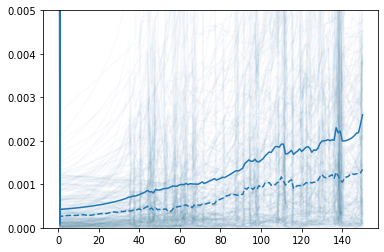

In [ ]:
# time series plot of angle penalties

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.01);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

(0.0, 0.5)

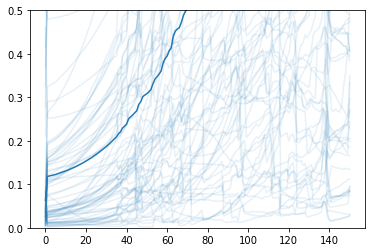

In [ ]:
# time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.1);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 5*1e-1])

<matplotlib.collections.PathCollection>

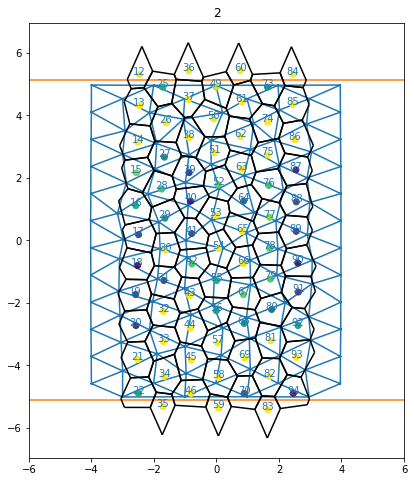

In [ ]:
# spatial plot of shape energies

i = 2

fig = plt.figure(figsize=(8,8))

plt.hlines((max_y_cells, -max_y_cells), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-6, 6])
#plt.ylim([-max_y-.5, max_y+.5])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=5*1e-2)

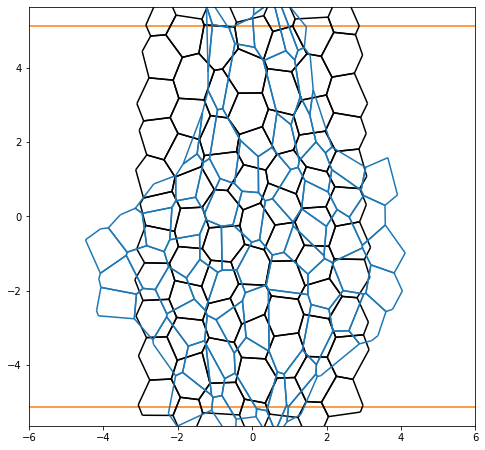

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.hlines((max_y_cells, -max_y_cells), (-7, -7), (7, 7), color="tab:orange")
plt.xlim([-6, 6])
plt.gca().set_aspect("equal", adjustable="box")
meshes[1].cellplot()
meshes[-1].cellplot(edge_colors={he: "tab:blue" for he in meshes[-1].hes.keys()})


(0.0, 1.7320508075688772)

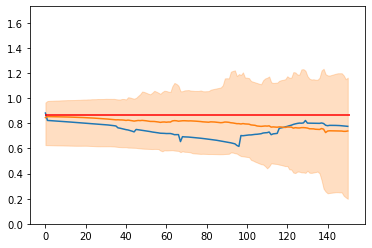

In [ ]:
# create a time-series of areas

areas = np.empty((len(meshes), len(meshes[0].vertices)))
for t, msh in enumerate(meshes):
    for v in msh.vertices.values():
        nghbs = v.get_face_neighbors()
        if (None in nghbs):
            areas[t, v._vid] = np.nan
        else: 
            areas[t, v._vid] = polygon_area(np.stack([fc.dual_coords for fc in nghbs]))
            
areas = areas[:, ~np.isnan(areas).any(axis=0)]

plt.plot(areas[:, 3])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])


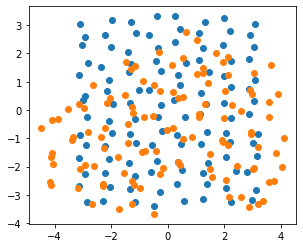

In [ ]:
# overlay initial and final positions of active cell vertices

initial = np.stack([meshes[1].faces[x].dual_coords for x in active_ids])
final = np.stack([meshes[-1].faces[x].dual_coords for x in active_ids])

plt.scatter(*initial.T)
plt.scatter(*final.T)

plt.gca().set_aspect("equal", adjustable="box")

In [ ]:
#| notest
%matplotlib inline

<IPython.core.display.Javascript object>


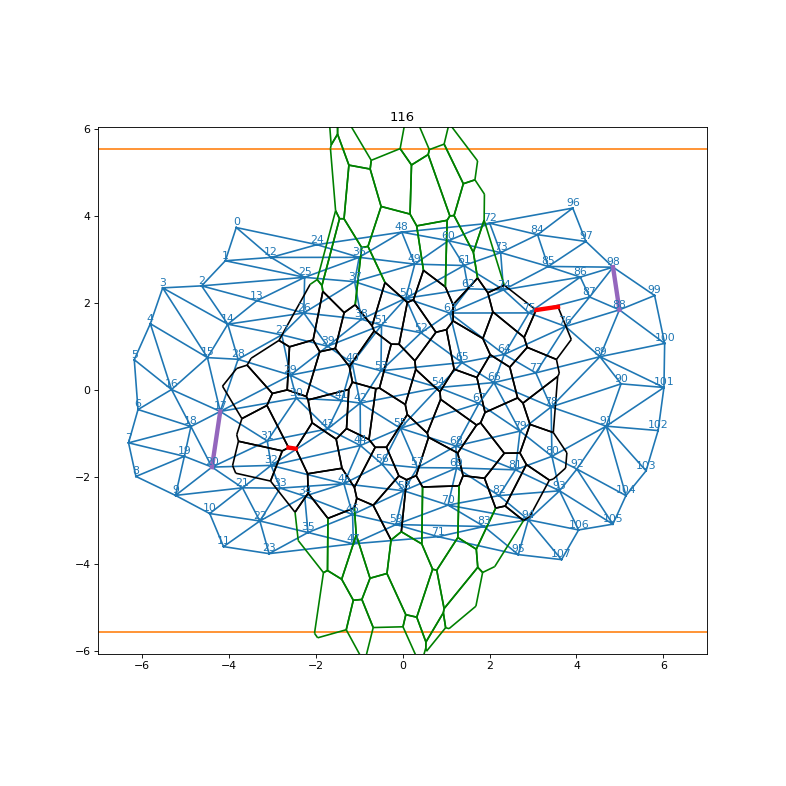

interactive(children=(IntSlider(value=75, description='i', max=151), Output()), _dom_classes=('widget-interact…

In [ ]:
#| notest

# Slider plot

%matplotlib notebook

fig = plt.figure(figsize=(10, 10))

def plot_mesh(i):
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-7, 7])
    plt.ylim([-max_y-.5, max_y+.5])
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors)#, cell_colors=cell_colors)
    meshes[i].labelplot(halfedge_labels=False, vertex_labels=True, face_labels=False)
    meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line.T, c="tab:purple", lw=4)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=4)
widgets.interact(plot_mesh, i=(0, len(meshes), 1));

In [ ]:
#| notest
%matplotlib inline


### Create and save an animation

In [ ]:
#| notest
%matplotlib inline

# Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

def animate_meshes(n):
    n = n+1
    plt.cla()
    plt.hlines((max_y, -max_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-7, 7])
    plt.ylim([-max_y-.5, max_y+.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[n].triplot()
    for x in last_flipped_edges[n+1]:
        he = meshes[n].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=2)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=2)
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=nframes-1, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_cells_only_colored_rows.mp4', fps=4,)
# maybe best to start from 1

## OLD STUFF